In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
import gym_anytrading
from collections import deque
import matplotlib.pyplot as plt

class REINFORCE(nn.Module):
    def __init__(self, input_dim, n_actions):
        super(REINFORCE, self).__init__()
        
        self.actor = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, state):
        probs = self.actor(state)
        return probs
    

    def get_log_prob_gradient(self, state, action):
        
        probs = self.forward(state)
        log_probs = torch.log(probs)
        log_prob_selected_action = log_probs[0, action]
        log_prob_selected_action.backward()
        
        gradients = {}
        for param in self.parameters():
            gradients[param] = param.grad.clone()
        self.zero_grad()
        
        return gradients

    def get_log_prob_gradient1(self, state, action):
        
        probs = self.forward(state)
        log_probs = torch.log(probs)
        log_prob_selected_action = log_probs[0, action]
        log_prob_selected_action.backward()
        
        gradients = {}
        for name, param in self.named_parameters():
            gradients[name] = param.grad.clone()
        self.zero_grad()
        
        
        return gradients
    
def calculate_cumulative_rewards(rewards, gamma=0.99):
    returns = []
    tot = 0
    pw = 0
    for r in reversed(rewards):
        
        tot = r + gamma ** pw * tot
        returns.insert(0, tot)
        pw += 1
    return returns

In [2]:
def train(env, model, episode, T, lr=0.01, gamma=0.99):
    state, _ = env.reset()
    
    episode_rewards = []
    episode_actions = []
    episode_states = []
    total_rewards = 0
    
    for t in range(T):
        state = state.flatten()
        state = torch.tensor([state], dtype=torch.float32)
        probs = model(state)
        distribution = torch.distributions.Categorical(probs)
        action = distribution.sample()
        next_state, reward, terminated, truncated, info = env.step(action.item())
        done = terminated or truncated
        total_rewards += reward
        
        episode_rewards.append(reward)
        episode_actions.append(action)
        episode_states.append(next_state)
        if done:
            break
        
        state = next_state

    discounted_values = calculate_cumulative_rewards(episode_rewards)
    for i in range(len(episode_actions)):
        
        curr_update_state = torch.tensor([episode_states[i].flatten()], dtype=torch.float32)
        curr_update_reward = discounted_values[i]
        curr_update_action = episode_actions[i]
        
        gradients = model.get_log_prob_gradient(curr_update_state, curr_update_action)
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        with torch.no_grad():
            for param in model.parameters():
                param += lr * (gamma ** (i+1)) * curr_update_reward * gradients[param]
    
    return total_rewards, info



In [6]:
# Get the environment
env = gym.make('forex-v0', frame_bound=(10, 500), window_size=10)

input_dim = env.observation_space.shape[1] * env.observation_space.shape[0]
n_actions = env.action_space.n

model = REINFORCE(input_dim, n_actions)
T = env.frame_bound[1] - env.frame_bound[0]

num_episodes = 300
for episode in range(num_episodes):
    reward, info = train(env, model, episode, T)
    print(f"Episode: {episode+1}, Reward: {reward}")
    print("info: ", info)
    print()

Episode: 1, Reward: 348.89698028564453
info:  {'total_reward': 348.89698028564453, 'total_profit': 0.9716049494195014, 'position': <Positions.Short: 0>}

Episode: 2, Reward: 296.095609664917
info:  {'total_reward': 296.095609664917, 'total_profit': 0.9731552634154337, 'position': <Positions.Long: 1>}

Episode: 3, Reward: -86.32063865661621
info:  {'total_reward': -86.32063865661621, 'total_profit': 0.953327650785021, 'position': <Positions.Short: 0>}

Episode: 4, Reward: 321.2904930114746
info:  {'total_reward': 321.2904930114746, 'total_profit': 0.9718974342498057, 'position': <Positions.Short: 0>}

Episode: 5, Reward: 104.90179061889648
info:  {'total_reward': 104.90179061889648, 'total_profit': 0.9640165521615753, 'position': <Positions.Short: 0>}

Episode: 6, Reward: -113.48843574523926
info:  {'total_reward': -113.48843574523926, 'total_profit': 0.9559431347936943, 'position': <Positions.Short: 0>}

Episode: 7, Reward: -175.9016513824463
info:  {'total_reward': -175.9016513824463,

KeyboardInterrupt: 

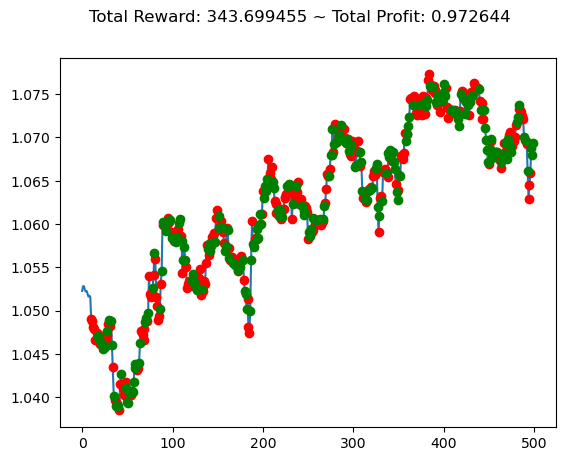

In [4]:
plt.cla()
env.unwrapped.render_all()
plt.show()